# Project 1
### Group Member:
1. Yihan Chen (yc4601)
2. Jiadi Ma (jm5865)

In [1]:
## Step 1: Clean the data.

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

# Read the data.
SnP_ratings_df = pd.read_pickle('1.0 S&P ratings.pickle')

# Remove the duplicated rows.
SnP_ratings_df = SnP_ratings_df.drop_duplicates()

# Keep the row with the latest ratingenddate for each gvkey + ratingdate combo
# If there's an overlap in ratings for a company, this keeps the ratings that last for the longest period
SnP_ratings_df = SnP_ratings_df.sort_values(by=['gvkey', 'ratingdate', 'ratingenddate'], ascending=[True, True, False])
SnP_ratings_df = SnP_ratings_df.drop_duplicates(subset=['gvkey', 'ratingdate'], keep='first')

# Test duplicates
print("Remaining full duplicates:", SnP_ratings_df.duplicated().sum())

# Test overlaping data
# Add the next rating start date per gvkey
SnP_ratings_df['next_ratingdate'] = SnP_ratings_df.groupby('gvkey')['ratingdate'].shift(-1)

# Compare current ratingenddate to next ratingdate
SnP_ratings_df['overlap'] = SnP_ratings_df['ratingenddate'] > SnP_ratings_df['next_ratingdate']

# Filter overlapping rows for inspection
overlaps = SnP_ratings_df[SnP_ratings_df['overlap'] == True]

# Print how many overlaps were found
print(f"Overlapping rows found: {overlaps.shape[0]}")

SnP_ratings_df


Remaining full duplicates: 0
Overlapping rows found: 0


,gvkey,ratingdate,ratingsymbol,default_date,withdrawal_date,ratingenddate,next_ratingdate,overlap
0,001004,1995-01-23,BBB-,2999-12-31,2025-02-14,1997-07-03,1997-07-03,False
1,001004,1997-07-03,BBB,2999-12-31,2025-02-14,2002-01-10,2002-01-10,False
2,001004,2002-01-10,BBB-,2999-12-31,2025-02-14,2003-04-18,2003-04-18,False
3,001004,2003-04-18,BB-,2999-12-31,2025-02-14,2006-10-13,2006-10-13,False
4,001004,2006-10-13,BB,2999-12-31,2025-02-14,2015-04-03,2015-04-03,False
...,...,...,...,...,...,...,...,...
40416,359645,2024-12-11,NR,2999-12-31,2024-12-11,2999-12-31,NaN,False
40417,360332,2025-02-21,NR,2999-12-31,2025-02-21,2999-12-31,NaN,False
40418,365883,2025-03-11,BB-,2999-12-31,2999-12-31,2999-12-31,NaN,False
40419,365900,2024-12-04,B,2999-12-31,2999-12-31,2025-03-21,2025-03-21,False


In [2]:
## Step 2: Identify rating defaulters.

# We know that the "D","SD","R" rating represents default.
SnP_ratings_df['default'] = SnP_ratings_df['ratingsymbol'].isin(['D', 'SD', 'R'])
defaulters = SnP_ratings_df[SnP_ratings_df['default']].groupby('gvkey')['ratingdate'].min().reset_index()
defaulters.columns = ['gvkey', 'default_date']

print(f'\nThe number of defaulters are {len(defaulters)}.')

#measure defaults by dates
SnP_ratings_df['default_date'] = pd.to_datetime(SnP_ratings_df['default_date'], errors='coerce')
SnP_ratings_df['is_default'] = SnP_ratings_df['default_date'].notna()

# Get earliest default date per gvkey from default_date column
default_by_flag = SnP_ratings_df[SnP_ratings_df['is_default']].groupby('gvkey')['default_date'].min().reset_index()
default_by_flag.columns = ['gvkey', 'default_date']

defaulters


The number of defaulters are 1200.


,gvkey,default_date
0,001045,2011-11-29
1,001059,1999-01-27
2,001081,2009-03-31
3,001308,2009-06-29
4,001382,2002-06-25
...,...,...
1195,323393,2021-12-09
1196,323554,2022-11-29
1197,324989,2018-05-17
1198,325248,2024-03-27


In [3]:
## Step 3: Identify rating withdrawals.

# Detect withdrawals using actual withdrawal_date
SnP_ratings_df['withdrawal_date'] = pd.to_datetime(SnP_ratings_df['withdrawal_date'], errors='coerce')
SnP_ratings_df['Withdrawn_by_date'] = SnP_ratings_df['withdrawal_date'].notna()

# We know that the "NR" means withdraw.
SnP_ratings_df['Withdrawn'] = SnP_ratings_df['ratingsymbol'].str.contains('NR')
last_rating = SnP_ratings_df.groupby('gvkey')['ratingdate'].max().reset_index()
last_rating.columns = ['gvkey', 'last_date']

withdrawals = SnP_ratings_df[SnP_ratings_df['Withdrawn']].groupby('gvkey')['ratingdate'].min().reset_index()
withdrawals.columns = ['gvkey', 'withdrawn_date']

# Combine defaulters and withdrawals.
exit_info = pd.merge(last_rating, defaulters, on='gvkey', how='left')
exit_info = pd.merge(exit_info, withdrawals, on='gvkey', how='left')

# Determine exit reason.
def choose_exit(row):
    if pd.notnull(row['default_date']):
        return 'default'
    elif pd.notnull(row['withdrawn_date']) and (
        (row['withdrawn_date'] - row['last_date']).days <= 365):
        return 'withdrawn'
    else:
        return 'active'

exit_info['exit_type'] = exit_info.apply(choose_exit, axis=1)
exit_info[['gvkey', 'last_date', 'default_date', 'withdrawn_date', 'exit_type']]

print(f'\nThe number of withdrawls are {len(withdrawals)}.')
print(f'\nTrue withdrawals (exit_info) are {len(exit_info)}.')

exit_info



The number of withdrawls are 6770.

True withdrawals (exit_info) are 8555.


,gvkey,last_date,default_date,withdrawn_date,exit_type
0,001004,2025-02-14,NaN,2025-02-14,withdrawn
1,001034,2009-02-26,NaN,2009-02-26,withdrawn
2,001036,2001-05-25,NaN,2001-05-25,withdrawn
3,001045,2011-11-29,2011-11-29,NaN,default
4,001048,2019-05-01,NaN,2019-05-01,withdrawn
...,...,...,...,...,...
8550,359443,2024-08-29,NaN,NaN,active
8551,359645,2024-12-11,NaN,2024-12-11,withdrawn
8552,360332,2025-02-21,NaN,2025-02-21,withdrawn
8553,365883,2025-03-11,NaN,NaN,active


In [4]:
## Step 4 Creat Annual Cohort

# Create a clean base DataFrame
ratings = SnP_ratings_df[['gvkey', 'ratingdate', 'ratingenddate', 'ratingsymbol']]

# Merge default and withdrawn info directly
ratings = ratings.merge(defaulters, on='gvkey', how='left')
ratings = ratings.merge(withdrawals, on='gvkey', how='left')

ratings['ratingdate'] = pd.to_datetime(ratings['ratingdate'], errors='coerce')
ratings['ratingenddate'] = pd.to_datetime(ratings['ratingenddate'], errors='coerce')

# Create year-end cohort dates
cohort_dates = [dt.date(year, 12, 31) for year in range(1989, 2025)]

# Prepare cohort output
cohort_data = pd.DataFrame()

for date in cohort_dates:
    cohort_date = pd.Timestamp(date)
    # Filter entities rated at this date
    active = ratings[
        (ratings['ratingdate'] <= cohort_date) &
        (ratings['ratingenddate'] > cohort_date)
    ].copy()
    active['cohort_date'] = cohort_date
    active['plus_one_year'] = cohort_date + relativedelta(years=1)

    # Flag default or withdrawal within 1 year
    active['default_flag'] = (
        (active['default_date'].notna()) &
        (active['default_date'] > cohort_date.date()) &
        (active['default_date'] <= cohort_date.date() + relativedelta(years=1))
    ).astype(int)

    active['withdrawn_flag'] = (
        (active['default_flag'] == 0) &
        (active['withdrawn_date'].notna()) &
        (active['withdrawn_date'] > cohort_date.date()) &
        (active['withdrawn_date'] <= active['plus_one_year'])
    ).astype(int)

    # Classify exit type
    def classify(row):
        if row['default_flag']:
            return 'default'
        elif row['withdrawn_flag']:
            return 'withdrawn'
        else:
            return 'active'

    active['cohort_exit_type'] = active.apply(classify, axis=1)

    cohort_data = pd.concat([cohort_data, active])

print(cohort_data['cohort_exit_type'].value_counts())
cohort_data

cohort_exit_type
active       78383
withdrawn     6123
default       1175
Name: count, dtype: int64


,gvkey,ratingdate,ratingenddate,ratingsymbol,default_date,withdrawn_date,cohort_date,plus_one_year,default_flag,withdrawn_flag,cohort_exit_type
13,001045,1990-08-20,1991-04-05,A-,2011-11-29,NaN,1990-12-31,1991-12-31,0,0,active
174,001240,1990-06-19,1999-06-24,A+,NaN,2024-08-09,1990-12-31,1991-12-31,0,0,active
224,001336,1990-11-20,1997-07-16,AA-,NaN,1997-07-16,1990-12-31,1991-12-31,0,0,active
237,001388,1990-08-20,1991-04-05,A-,2011-11-29,NaN,1990-12-31,1991-12-31,0,0,active
319,001594,1990-04-24,1999-04-19,B,2001-08-21,NaN,1990-12-31,1991-12-31,0,0,active
...,...,...,...,...,...,...,...,...,...,...,...
40379,350764,2021-11-15,2025-05-21,B+,NaN,2025-05-21,2024-12-31,2025-12-31,0,1,withdrawn
40398,352012,2022-09-21,2025-03-04,BBB+,NaN,NaN,2024-12-31,2025-12-31,0,0,active
40404,353444,2022-07-21,2025-05-10,BBB,NaN,2025-05-10,2024-12-31,2025-12-31,0,1,withdrawn
40410,356706,2023-05-12,2025-03-21,BB-,NaN,NaN,2024-12-31,2025-12-31,0,0,active


In [5]:
## Step 5: S&P Default Rate Method:

# Ensure datetime columns are in correct format
cohort_data['cohort_date'] = pd.to_datetime(cohort_data['cohort_date'])
cohort_data['ratingdate'] = pd.to_datetime(cohort_data['ratingdate'])

# Get the first observed rating on each cohort date
cohort_data_sorted = cohort_data.sort_values(by=['gvkey', 'cohort_date', 'ratingdate'])
initial_ratings = cohort_data_sorted.groupby(['gvkey', 'cohort_date']).first().reset_index()
initial_ratings = initial_ratings[['gvkey', 'cohort_date', 'ratingsymbol', 'default_flag']]

# Filter out unwanted ratings
exclude = ['NR', 'SD', 'D', 'R']
initial_ratings = initial_ratings[~initial_ratings['ratingsymbol'].isin(exclude)]

# Marginal default rate by rating over 1–5 years
marginal_rates = {}
for year in range(1, 6):
    df = initial_ratings.copy()
    df['horizon'] = year
    marginal = df.groupby('ratingsymbol')['default_flag'].mean()
    marginal_rates[year] = marginal

marginal_df = pd.DataFrame(marginal_rates).fillna(0)

# Compute cumulative default rates using S&P marginal method
cumulative_df = pd.DataFrame(index=marginal_df.index)
for year in range(1, 6):
    if year == 1:
        cumulative_df[year] = marginal_df[1]
    else:
        cumulative_df[year] = cumulative_df[year - 1] + (1 - cumulative_df[year - 1]) * marginal_df[year]

# Format as percent strings
cumulative_pct = (cumulative_df * 100).round(2).astype(str) + '%'

# Order ratings from highest to lowest (standard S&P order)
rating_order = [
    'AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-',
    'BBB+', 'BBB', 'BBB-',
    'BB+', 'BB', 'BB-',
    'B+', 'B', 'B-',
    'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'Ca-C'
]

# Add fallback mapping to group any low-end ratings into 'Ca-C' if needed
cumulative_pct['rating_clean'] = cumulative_pct.index.map(
    lambda x: x if x in rating_order else 'Ca-C'
)
cumulative_pct = cumulative_pct.groupby('rating_clean').first()

# Reindex based on desired order
final_table = cumulative_pct.reindex([r for r in rating_order if r in cumulative_pct.index])

# Display the clean table
final_table.columns = ['Year1', 'Year2', 'Year3', 'Year4', 'Year5']
final_table.index.name = 'Rating'
final_table.reset_index(inplace=True)

# Show table
print("\nS&P Cumulative Default Rate Table (1–5 Years):\n")

final_table



S&P Cumulative Default Rate Table (1–5 Years):



,Rating,Year1,Year2,Year3,Year4,Year5
0,AAA,0.0%,0.0%,0.0%,0.0%,0.0%
1,AA+,0.0%,0.0%,0.0%,0.0%,0.0%
2,AA,0.0%,0.0%,0.0%,0.0%,0.0%
3,AA-,0.03%,0.07%,0.1%,0.14%,0.17%
4,A+,0.07%,0.15%,0.22%,0.3%,0.37%
5,A,0.02%,0.03%,0.05%,0.06%,0.08%
6,A-,0.07%,0.15%,0.22%,0.29%,0.36%
7,BBB+,0.1%,0.2%,0.3%,0.4%,0.49%
8,BBB,0.08%,0.16%,0.24%,0.32%,0.4%
9,BBB-,0.14%,0.27%,0.41%,0.54%,0.68%


In [ ]:
## Step 6: Moody's Default Rate Method.

# Reuse cleaned cohort_data
cohort_data['cohort_date'] = pd.to_datetime(cohort_data['cohort_date'])

# First rating per gvkey per cohort
cohort_data_sorted = cohort_data.sort_values(by=['gvkey', 'cohort_date', 'ratingdate'])
initial_ratings = cohort_data_sorted.groupby(['gvkey', 'cohort_date']).first().reset_index()
initial_ratings = initial_ratings[['gvkey', 'cohort_date', 'ratingsymbol']]

# Exclude bad symbols
initial_ratings = initial_ratings[~initial_ratings['ratingsymbol'].isin(['NR', 'SD', 'D', 'R'])]

# Merge back the flags (default and withdrawn) for all horizons
merged = pd.merge(
    initial_ratings,
    cohort_data[['gvkey', 'cohort_date', 'default_flag', 'withdrawn_flag']],
    on=['gvkey', 'cohort_date'],
    how='left'
)

# Prepare storage for Moody's marginal rates
moody_marginal = {}

# Loop over 1 to 5 years
for year in range(1, 6):
    temp = merged.copy()
    temp['horizon'] = year

    # Define numerator and denominator per Moody's logic
    grouped = temp.groupby('ratingsymbol').agg(
        defaults=('default_flag', lambda x: (x == 1).sum()),
        withdrawals=('withdrawn_flag', lambda x: (x == 1).sum()),
        total=('gvkey', 'count')
    )

    # Moody's marginal rate
    grouped['moody_marginal'] = grouped['defaults'] / (grouped['total'] - 0.5 * grouped['withdrawals'])
    moody_marginal[year] = grouped['moody_marginal']

# Combine into DataFrame
moody_marginal_df = pd.DataFrame(moody_marginal).fillna(0)

# Apply cumulative formula
moody_cum_df = pd.DataFrame(index=moody_marginal_df.index)
for year in range(1, 6):
    if year == 1:
        moody_cum_df[year] = moody_marginal_df[1]
    else:
        moody_cum_df[year] = moody_cum_df[year - 1] + (1 - moody_cum_df[year - 1]) * moody_marginal_df[year]

# Format as percent
moody_pct = (moody_cum_df * 100).round(2).astype(str) + '%'

# Reorder by S&P rating scale
rating_order = [
    'AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-',
    'BBB+', 'BBB', 'BBB-',
    'BB+', 'BB', 'BB-',
    'B+', 'B', 'B-',
    'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'Ca-C'
]

# Clean and reindex
moody_pct['rating_clean'] = moody_pct.index.map(lambda x: x if x in rating_order else 'Ca-C')
moody_pct = moody_pct.groupby('rating_clean').first()
final_moody = moody_pct.reindex([r for r in rating_order if r in moody_pct.index])
final_moody.columns = ['Year1', 'Year2', 'Year3', 'Year4', 'Year5']
final_moody.index.name = 'Rating'
final_moody.reset_index(inplace=True)

# Display Moody's cumulative default rate table
print("\nMoody’s Cumulative Default Rate Table (1–5 Years):\n")

final_moody



Moody’s Cumulative Default Rate Table (1–5 Years):



,Rating,Year1,Year2,Year3,Year4,Year5
0,AAA,0.0%,0.0%,0.0%,0.0%,0.0%
1,AA+,0.0%,0.0%,0.0%,0.0%,0.0%
2,AA,0.0%,0.0%,0.0%,0.0%,0.0%
3,AA-,0.03%,0.07%,0.1%,0.14%,0.17%
4,A+,0.08%,0.15%,0.23%,0.31%,0.39%
5,A,0.02%,0.03%,0.05%,0.06%,0.08%
6,A-,0.08%,0.15%,0.23%,0.3%,0.37%
7,BBB+,0.1%,0.2%,0.31%,0.41%,0.51%
8,BBB,0.08%,0.16%,0.25%,0.33%,0.41%
9,BBB-,0.14%,0.28%,0.42%,0.56%,0.7%


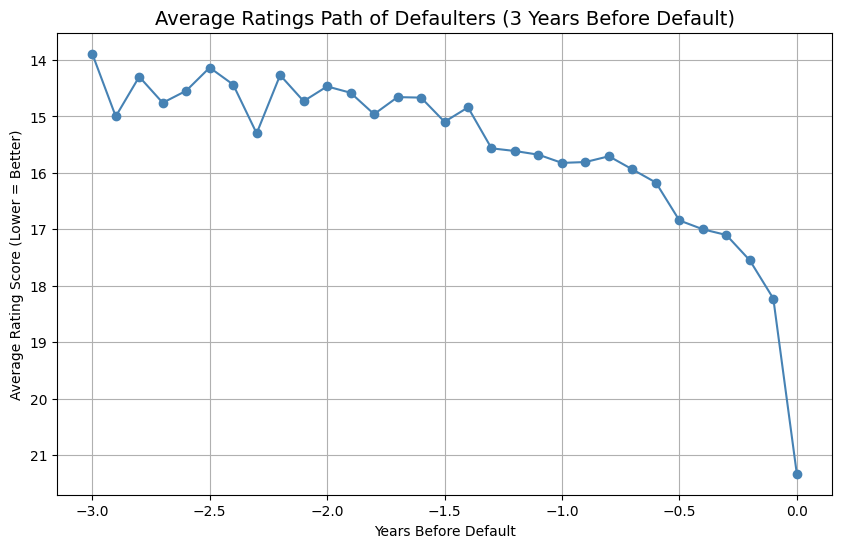

In [ ]:
## Step 7: Average Ratings Path of All Default Ratings from Three Years Prior to Default until Default.

# Get earliest default date per gvkey
default_events = SnP_ratings_df[SnP_ratings_df['ratingsymbol'].isin(['D', 'SD', 'R'])].copy()
default_events['ratingdate'] = pd.to_datetime(default_events['ratingdate'], errors='coerce')
default_events.rename(columns={'ratingdate': 'default_date'}, inplace=True)
default_dates = default_events.groupby('gvkey')['default_date'].min().reset_index()

# Merge default dates into ratings history
df = SnP_ratings_df.copy()
df['ratingdate'] = pd.to_datetime(df['ratingdate'], errors='coerce')
df = df.merge(default_dates, on='gvkey', how='inner')

# Remove duplicate 'default_date_y' column
if 'default_date_y' in df.columns and df.columns.tolist().count('default_date_y') > 1:
    # Keep the last occurrence which is the result of the merge
    df = df.loc[:,~df.columns.duplicated(keep='last')]

# Keep only ratings in the 3 years prior to default
df['default_date_y'] = pd.to_datetime(df['default_date_y'], errors='coerce')
df['days_to_default'] = (df['default_date_y'] - df['ratingdate']).dt.days
df = df[(df['days_to_default'] >= 0) & (df['days_to_default'] <= 3 * 365)]

# Calculate years before default (rounded to nearest 0.1)
df['years_before_default'] = -(df['days_to_default'] / 365).round(1)

# Map ratings to numeric values
RATING_SCALE = {
    'AAA': 1, 'AA+': 2, 'AA': 3, 'AA-': 4,
    'A+': 5, 'A': 6, 'A-': 7,
    'BBB+': 8, 'BBB': 9, 'BBB-': 10,
    'BB+': 11, 'BB': 12, 'BB-': 13,
    'B+': 14, 'B': 15, 'B-': 16,
    'CCC+': 17, 'CCC': 18, 'CCC-': 19,
    'CC': 20, 'C': 21, 'D': 22
}
df = df[df['ratingsymbol'].isin(RATING_SCALE)]
df['rating_numeric'] = df['ratingsymbol'].map(RATING_SCALE)

# Group and compute average rating by time to default
avg_path = df.groupby('years_before_default')['rating_numeric'].mean().sort_index()

# Plot the path
plt.figure(figsize=(10, 6))
plt.plot(avg_path.index, avg_path.values, marker='o', color='steelblue')
plt.gca().invert_yaxis()  # Better ratings (lower values) at top
plt.title("Average Ratings Path of Defaulters (3 Years Before Default)", fontsize=14)
plt.xlabel("Years Before Default")
plt.ylabel("Average Rating Score (Lower = Better)")
plt.grid(True)
# Adjust x-axis ticks
plt.xticks(np.arange(avg_path.index.min(), avg_path.index.max() + 0.5, 0.5))
plt.show()

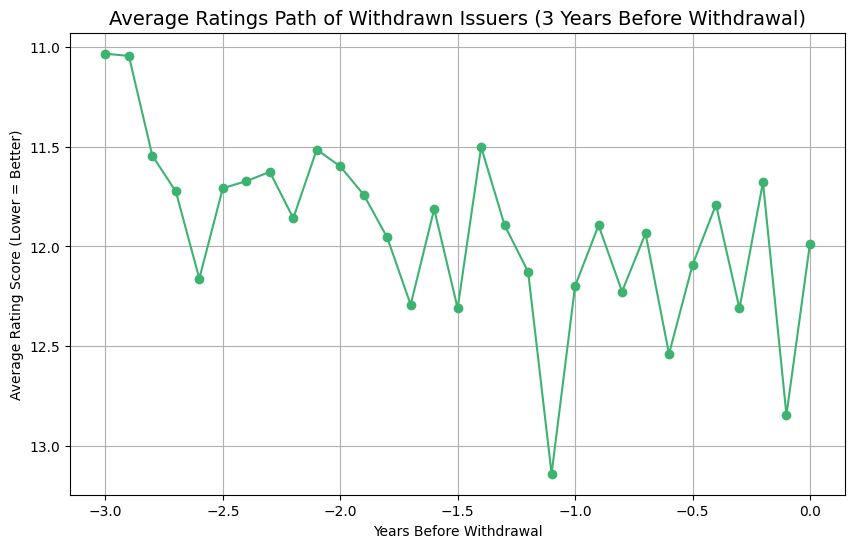

In [ ]:
## Step 8: Average Ratings Path of All Withdrawn Ratings from Three Years Prior to Withdrawn until Withdrawn.

# Get earliest withdrawal date per gvkey
withdrawn_events = SnP_ratings_df[SnP_ratings_df['ratingsymbol'] == 'NR'].copy()
withdrawn_events['ratingdate'] = pd.to_datetime(withdrawn_events['ratingdate'], errors='coerce')
withdrawn_events.rename(columns={'ratingdate': 'withdrawn_date'}, inplace=True)
withdrawn_dates = withdrawn_events.groupby('gvkey')['withdrawn_date'].min().reset_index()

# Merge withdrawal dates into ratings history
df = SnP_ratings_df.copy()
df['ratingdate'] = pd.to_datetime(df['ratingdate'], errors='coerce')
df = df.merge(withdrawn_dates, on='gvkey', how='inner')

# Handle duplicate withdrawal date columns if they exist
if 'withdrawn_date_y' in df.columns and df.columns.tolist().count('withdrawn_date_y') > 1:
    df = df.loc[:, ~df.columns.duplicated(keep='last')]

# Keep ratings from the 3 years before withdrawal
df['withdrawn_date'] = pd.to_datetime(df['withdrawn_date'], errors='coerce')
df['days_to_withdrawn'] = (df['withdrawn_date'] - df['ratingdate']).dt.days
df = df[(df['days_to_withdrawn'] >= 0) & (df['days_to_withdrawn'] <= 3 * 365)]

# Calculate years before withdrawal
df['years_before_withdrawn'] = -(df['days_to_withdrawn'] / 365).round(1)

# Map ratings to numeric values
RATING_SCALE = {
    'AAA': 1, 'AA+': 2, 'AA': 3, 'AA-': 4,
    'A+': 5, 'A': 6, 'A-': 7,
    'BBB+': 8, 'BBB': 9, 'BBB-': 10,
    'BB+': 11, 'BB': 12, 'BB-': 13,
    'B+': 14, 'B': 15, 'B-': 16,
    'CCC+': 17, 'CCC': 18, 'CCC-': 19,
    'CC': 20, 'C': 21, 'D': 22
}
df = df[df['ratingsymbol'].isin(RATING_SCALE)]
df['rating_numeric'] = df['ratingsymbol'].map(RATING_SCALE)

# Group and compute average rating
avg_path = df.groupby('years_before_withdrawn')['rating_numeric'].mean().sort_index()

# Plot the path
plt.figure(figsize=(10, 6))
plt.plot(avg_path.index, avg_path.values, marker='o', color='mediumseagreen')
plt.gca().invert_yaxis()
plt.title("Average Ratings Path of Withdrawn Issuers (3 Years Before Withdrawal)", fontsize=14)
plt.xlabel("Years Before Withdrawal")
plt.ylabel("Average Rating Score (Lower = Better)")
plt.grid(True)
plt.xticks(np.arange(avg_path.index.min(), avg_path.index.max() + 0.5, 0.5))
plt.show()


## AI Use Statement
This notebook structure and documentation were generated using OpenAI’s ChatGPT, with code and markdown adapted for clarity and submission. All logic has been reviewed for correctness.

## References
- S&P Global Ratings default study methodology
- Moody’s Investor Services default rate research
- PEP 8 and PEP 257 coding and documentation standards